In [1]:
NAME1 = "Caroline Andersson" 
NAME2 = "Adam Burman"
GROUP = "84"

In [2]:
### Check Python version
from platform import python_version_tuple
assert python_version_tuple()[:2] == ('3','9'), "You are not running Python 3.9. Make sure to run Python through the course Conda environment."

### 1.1 Imports

In [3]:


path = r"C:\Users\carol\Deep Machine Learning\project\Dataset"

import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms import Resize
from torchvision.transforms import CenterCrop
from pathlib import Path
import torchvision.transforms
import torch.nn.functional as F
from torch.utils.data import random_split

from torch import nn
from torch import optim

import matplotlib.pyplot as plt
import numpy as np

import torchvision.transforms as transforms
#import colorspacious as cs


import kornia # https://kornia.readthedocs.io/en/latest/color.html
#Lab color is computed using the D65 illuminant and Observer 2. (deafult in kornia)


from torchvision.transforms import Compose

In [4]:
# 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

### 1.2 Load Data

Make a dataloader class

### 1.2.1 Load GTA Data and Return L, ab // or [1, s, s], [2, s, s]

In [5]:
from torch.utils.data import Dataset
from itertools import chain
from PIL import Image
import glob
import os

class GTALabData(Dataset):
    

    def __init__(self, root, transform = None):
            """Constructor
        
        Args:
            root (Path/str): Filepath to the data root
            transform (Compose): A composition of image transforms.
        """
            root = Path(root)
            if not (root.exists() and root.is_dir()):
                raise ValueError(f"Data root '{root}' is invalid")
            
            self.root = root
            self.transform = transform
            self.img_paths, self.label_paths = self._collect_samples()
            
       
    def __getitem__(self, index):
        """Get sample by index
        
        Args:
            index (int)
        
        Returns:
             The index'th sample Tensor
        """
        
        img_path = self.img_paths[index]
        label_path = self.label_paths[index]

        # Load the image and label into memory
        img = Image.open(img_path)
        #label = Image.open(label_path)
        img1 = torchvision.transforms.functional.pil_to_tensor(img) # PIL --> Tensor
        img = kornia.color.rgb_to_lab(img1/255) # RGB --> Lab
        
        L = img[0]#kornia.color.rgb_to_grayscale(img1/255)#img[0]
        a = img[1]
        b = img[2]

        # Perform transforms, if any.
        if self.transform is not None:
            L = self.transform(L.numpy()) # transform L
            a = self.transform(a.numpy()) # transform
            b = self.transform(b.numpy()) # transform
            
            
        
        
        ab = torch.cat((a.unsqueeze(0), b.unsqueeze(0)), dim=0).squeeze()
        #L = torch.cat((L.unsqueeze(0), L.unsqueeze(0), L.unsqueeze(0)), dim=0).squeeze()

        return (L-50)/50, ab/128
    
    def __len__(self):
        """Get the number of samples in the dataset"""
        return len(self.img_paths)
    
    def _collect_samples(self):
        """Collect all paths and labels
        
        Helper method for the constructor
        """
        """Collect all paths and labels

        Helper method for the constructor
        """
        
        
        # Get image and label paths
        img_dir = self.root / "01_images" / "images"
        label_dir = self.root / "01_labels" / "labels"
        
        # check if there are images in the directory
        #self._check_images_in_directory(img_dir)
        #self._check_images_in_directory(label_dir)

        img_paths = list(img_dir.glob("*.png"))
        label_paths = list(label_dir.glob("*.png"))

        if len(img_paths) != len(label_paths):
            raise ValueError("Number of images and labels must be the same")
            
        return img_paths, label_paths

In [6]:

#transform = Compose([ToTensor()])

example_dataset = GTALabData(path)
print(len(example_dataset)) #1
L, ab = example_dataset[2]
#print(img)
print(L.dtype)
print(L.shape)
print(ab.shape)
print(np.max(L.numpy()))

2500
torch.float32
torch.Size([1052, 1914])
torch.Size([2, 1052, 1914])
1.0


### 1.2.1 Load GTA Data and Return L, (L, segmented image) // or [1, s, s], [2, s, s]

In [7]:

# GTASemanticData
# Note: there are 19 semantic classes
from torch.utils.data import Dataset
from itertools import chain
from PIL import Image
import glob
import os

class GTASegData(Dataset):
    

    def __init__(self, root, transform = None):
            """Constructor
        
        Args:
            root (Path/str): Filepath to the data root
            transform (Compose): A composition of image transforms.
        """
            root = Path(root)
            if not (root.exists() and root.is_dir()):
                raise ValueError(f"Data root '{root}' is invalid")
            
            self.root = root
            self.transform = transform
            self.img_paths, self.label_paths = self._collect_samples()
            
       
    def __getitem__(self, index):
        """Get sample by index
        
        Args:
            index (int)
        
        Returns:
             The index'th sample Tensor
        """
        
        img_path = self.img_paths[index]
        label_path = self.label_paths[index]

        # Load the image and label into memory
        img = Image.open(img_path)
        label = Image.open(label_path)
        
        img1 = torchvision.transforms.functional.pil_to_tensor(img) # PIL --> Tensor
        img = kornia.color.rgb_to_lab(img1/255) # RGB --> Lab



       
        L = img[0]
        a = img[1]
        b = img[2]

        

        # Perform transforms, if any.
        if self.transform is not None:
            L = self.transform(L.numpy()) # transform L
            label = self.transform(label) # transform
            a = self.transform(a.numpy()) # transform
            b = self.transform(b.numpy()) # transform

        label1 =np.moveaxis(label.numpy()*255, 0, -1)
        label1 = torch.from_numpy(label1).float().permute(2,0,1).int() # turn label into integers after resize transform
        
        # Generate 35 tensors with zeros
        
        zeros = torch.zeros((35,L.shape[1], L.shape[2]))
       
        for value in range(35):
            find_class = (label1 == value).float()
            zeros[value] = label1*find_class
        
            

        #n_digits = 2
        #label = torch.round(label * 10**n_digits) / (10**n_digits) #round to 3 decimals
        
        
        
        
        
        
        ab = torch.cat((a.unsqueeze(0), b.unsqueeze(0)), dim=0).squeeze()
        out = torch.cat((L.unsqueeze(0)/100, label.unsqueeze(0)), dim=0).squeeze()

        return L/100, label1 # normalize L between [0, 1] to fit in cross entropy loss
    
    def __len__(self):
        """Get the number of samples in the dataset"""
        return len(self.img_paths)
    
    def _collect_samples(self):
        """Collect all paths and labels
        
        Helper method for the constructor
        """
        """Collect all paths and labels

        Helper method for the constructor
        """
        
        
        # Get image and label paths
        img_dir = self.root / "01_images" / "images"
        label_dir = self.root / "01_labels" / "labels"
        
        # check if there are images in the directory
        #self._check_images_in_directory(img_dir)
        #self._check_images_in_directory(label_dir)

        img_paths = list(img_dir.glob("*.png"))
        label_paths = list(label_dir.glob("*.png"))

        if len(img_paths) != len(label_paths):
            raise ValueError("Number of images and labels must be the same")
            
        return img_paths, label_paths


torch.Size([1, 512, 512])


(-0.5, 511.5, 511.5, -0.5)

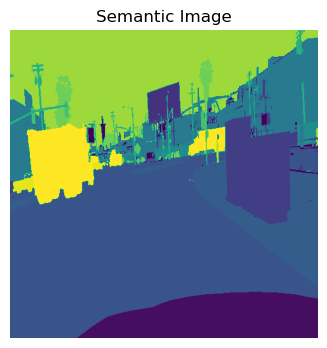

In [8]:
crop_size = (512, 512)
transform =  Compose([ToTensor(), Resize(crop_size, interpolation=Image.NEAREST)])
#transform =  Compose([ToTensor()])
example_dataset1 = GTASegData(path, transform)
L1, s = example_dataset1[5]
print(s.shape)
plt.figure(figsize=(8, 4))
plt.imshow(torch.sum(s, dim= 0).numpy().squeeze())
plt.title('Semantic Image')
plt.axis('off')

### 1.3 Augument

In [9]:
# Dataset 
mean = 52.37087932
std = 24.64118381
img_size = 128#224
#gta_transform = Compose([ToTensor(), Resize((img_size, img_size), antialias=True), Normalize(mean, std, inplace=False)]) 
gta_transform = Compose([ToTensor(), Resize((img_size, img_size), antialias=True)])
gta_dataset = GTALabData(path, gta_transform)

### 1.4 Chop up into train, val and test

In [10]:


# Calculate mean std
#temp_dataset = GTALabData(path, ToTensor())

#test_img,_ = gta_dataset[0]
#print(test_img)
'''
number_of_samples = len(temp_dataset)
dataset_mean = []
dataset_std = []
for image,_ in temp_dataset:
    imgArray = np.array(image)
    #print(imgArray)
    dataset_mean.append(np.mean(imgArray))
    dataset_std.append(np.std(imgArray))

print(np.min(dataset_mean))
dataset_mean = np.mean(dataset_mean)
dataset_std = np.mean(dataset_std)
'''


test_img, ab = gta_dataset[0]
print(np.max(test_img.numpy()))
print(np.min(test_img.numpy()))


val_ratio = 0.15
test_ratio = 0.15

n_samples = len(gta_dataset)
n_val_samples = int(n_samples * val_ratio)
n_test_samples = int(n_samples * test_ratio)
n_train_samples = n_samples - n_val_samples - n_test_samples

train_dataset, val_dataset, test_dataset = random_split(
    gta_dataset, [n_train_samples, n_val_samples, n_test_samples]
)

0.9710671
-0.9831371


##  2. Create an Autoenconder for the Raw images
vgg16 can be used as the encoder by using transfer learning with the gtaV images. Then a decoder has to be constructed from scratch to generate a new image. The raw images are used in this section and later on another autoencoder will be trained with segmented images (our labels).

### 2.1 Create the Class

In [11]:


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Endocer
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        #Decoder
        
        self.dconv1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dbn1 = nn.BatchNorm2d(128)
        self.dconv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dbn2 = nn.BatchNorm2d(64)
        self.dconv3 = nn.Conv2d(64, 2, kernel_size=3, padding=1)  # Output has 2 channels (ab color channels)
        self.relu = nn.LeakyReLU(inplace=True)
        self.tanh = nn.Tanh()

        self.dropout1 = nn.Dropout(0.5)  # Adjust the dropout probability as needed
        self.dropout2 = nn.Dropout(0.1)
        
    def forward(self, x):
        # Encoder
        
        x = self.conv1(x)

        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        
        x = self.dropout1(x)
        # Decoder
        
        x = self.dconv1(x)
        x = self.tanh(x)
        x = self.dbn1(x)
        x = self.dconv2(x)
        x = self.dbn2(x)
        x = self.tanh(x)
        x = self.dconv3(x)
        x = self.dropout2(x)
        
        
        x = self.tanh(x)
        
        # Perform upsampling to the desired size [1052, 1914]
        #x = F.interpolate(x, size=(1052, 1914), mode='bilinear', align_corners=False)
       
        
        return x




### 2.2 Train 

In [12]:
def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs + 1):
        model, train_loss = train_epoch(model, optimizer, loss_fn, train_loader, device, print_every)
        val_loss = validate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {train_loss:.3f}, "
              f"Val. loss: {val_loss:.3f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    return model, train_losses, val_losses

def train_epoch(model, optimizer, loss_fn, train_loader, device, print_every):
    model.train()
    train_loss_batches = []
    num_batches = len(train_loader)
    
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model(inputs)
        loss = loss_fn(z, labels)
        #print(np.min(z.detach().cpu().numpy())) #kan max bli 1????
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        if print_every is not None and batch_index % print_every == 0:
            model.train()
            print(f"Batch {batch_index}/{num_batches}: Train loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}")

    return model, sum(train_loss_batches) / len(train_loss_batches)

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model(inputs)
            batch_loss = loss_fn(z, labels)
            val_loss_cum += batch_loss.item()
    return val_loss_cum / len(val_loader)


In [55]:
# YOUR CODE HERE
batch_size = 32
base_model = AutoEncoder()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)



optimizer = optim.Adam(base_model.parameters(), lr =0.001)
loss_fn = nn.MSELoss()
num_epochs = 10
print_every = 2


    
trained_single_model, train_losses, val_losses = training_loop(base_model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every)

Starting training
Batch 2/55: Train loss: 0.294
Batch 4/55: Train loss: 0.271
Batch 6/55: Train loss: 0.076
Batch 8/55: Train loss: 0.017
Batch 10/55: Train loss: 0.035
Batch 12/55: Train loss: 0.009
Batch 14/55: Train loss: 0.016
Batch 16/55: Train loss: 0.015
Batch 18/55: Train loss: 0.006
Batch 20/55: Train loss: 0.011
Batch 22/55: Train loss: 0.008
Batch 24/55: Train loss: 0.005
Batch 26/55: Train loss: 0.008
Batch 28/55: Train loss: 0.005
Batch 30/55: Train loss: 0.005
Batch 32/55: Train loss: 0.005
Batch 34/55: Train loss: 0.004
Batch 36/55: Train loss: 0.004
Batch 38/55: Train loss: 0.004
Batch 40/55: Train loss: 0.003
Batch 42/55: Train loss: 0.004
Batch 44/55: Train loss: 0.003
Batch 46/55: Train loss: 0.003
Batch 48/55: Train loss: 0.003
Batch 50/55: Train loss: 0.003
Batch 52/55: Train loss: 0.003
Batch 54/55: Train loss: 0.003
Epoch 1/10: Train loss: 0.030, Val. loss: 0.003
Batch 2/55: Train loss: 0.003
Batch 4/55: Train loss: 0.003
Batch 6/55: Train loss: 0.003
Batch 8/55:

### 2.3 Evaluate Performance

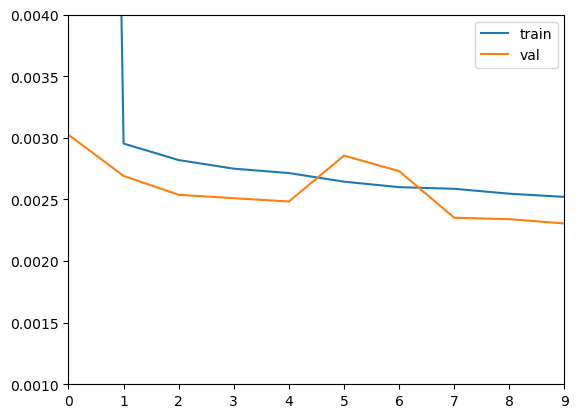

In [62]:
plt.figure()
plt.plot(range(0,len(train_losses)), train_losses)
plt.plot(range(0,len(val_losses)), val_losses)
plt.legend(['train', 'val'])
plt.ylim([0.001, 0.004])
plt.xlim([0, 9])
plt.show()
# Train loss: 0.013, Val. loss: 0.003

18.0219


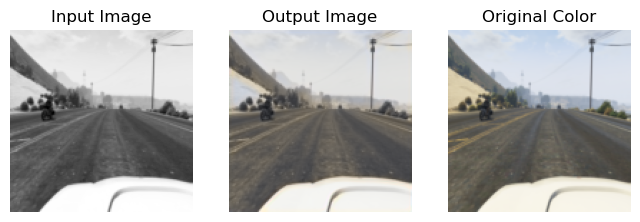

27.38561


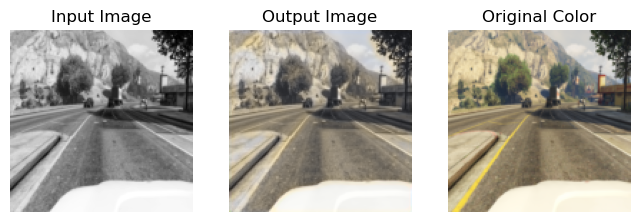

18.144978


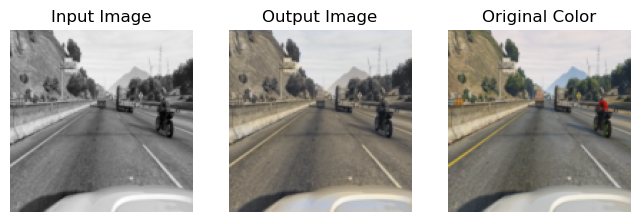

23.344688


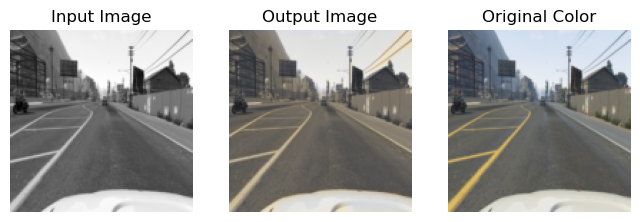

16.883806


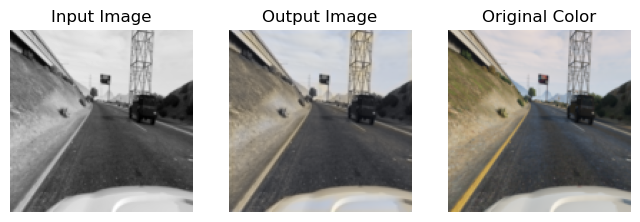

15.444447


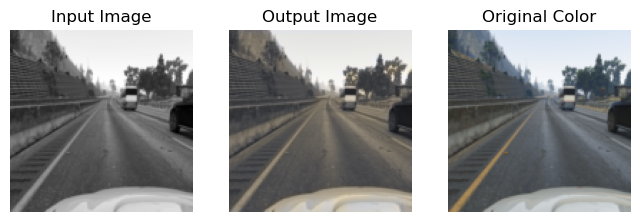

19.037624


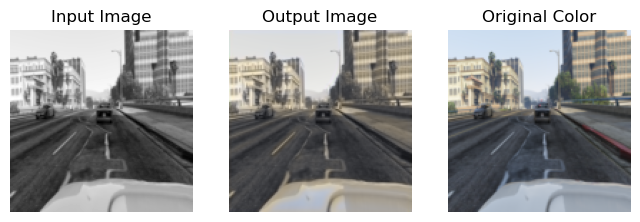

19.999249


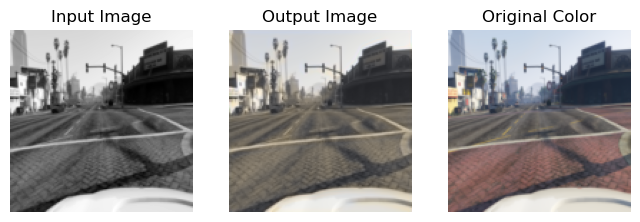

26.028042


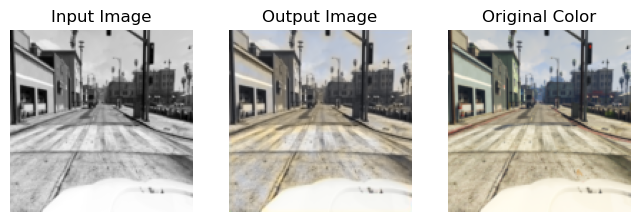

In [58]:

trained_single_model.eval()
test_image = train_dataset[0][0]
#print(test_image.shape)
batch_size = 10
# Iterate through the test data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

counter = 0
for batch in test_loader:
    inputs, labels = batch  # You can ignore the labels
    if counter == 3:
        break
    else:
        counter += 1

    # Perform inference
    with torch.no_grad():
        outputs = trained_single_model(inputs.to(device))

    # View the input and output images
    for i in range(3):
        input_img = inputs[i].squeeze().cpu()*50 + 50 # rescale [-1,1] --> [0, 100]
        input_labels = labels[i].squeeze().cpu()*128 # rescale [-1,1] --> [-128, 128]
        output_img = outputs[i].cpu()*128 # rescale [-1,1] --> [-128, 128]
        print(np.max(output_img.numpy()))
        

        # Network computed image
        color_img = torch.cat((input_img.unsqueeze(0) ,output_img[0].unsqueeze(0), output_img[1].unsqueeze(0)), dim=0).cpu() # restore Lab image
        color_img = kornia.color.lab_to_rgb(color_img) #Lab --> RGB
        color_img = color_img.permute(1, 2, 0).cpu().numpy()
        

        # Original Image
        input_labels = F.interpolate(input_labels.unsqueeze(1), size=(img_size, img_size), mode='bilinear', align_corners=False).squeeze(1).cpu()
        original_color_image = torch.cat((input_img.unsqueeze(0) ,input_labels[0].unsqueeze(0), input_labels[1].unsqueeze(0)), dim=0)
        original_color_image = kornia.color.lab_to_rgb(original_color_image)


        # Display the input and output images side by side
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(input_img, cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(color_img)
        plt.title('Output Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(original_color_image.permute(1, 2, 0).numpy())
        plt.title('Original Color')
        plt.axis('off')

        plt.show()

#output = trained_gta_model(test_image)
#test_dataloader = DataLoader()

### 2.4 Save Model

In [59]:
torch.save({'model_state_dict': trained_single_model.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            }, "./trained_single_model.ckpt")

# Example of creating and initialising model with a previously saved state dict:
saved_seg_model = AutoEncoder() # fill-in the arguments if needed
checkpoint = torch.load("trained_single_model.ckpt")
saved_seg_model.load_state_dict(checkpoint['model_state_dict'])

# Example of re-using saved statistics:
print("Validation accuracies:", checkpoint['val_losses'])

Validation accuracies: [0.00302524664827312, 0.0026912673104864857, 0.00253819222173964, 0.0025101784073437252, 0.00248371382864813, 0.0028562013370295367, 0.002730250300373882, 0.0023515253754643104, 0.002340329713964214, 0.002305300246613721]


## 3. Create a Network for Semantic Segmentation

In [19]:
def training_loop_seg(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs + 1):
        model, train_loss = train_epoch(model, optimizer, loss_fn, train_loader, device, print_every)
        val_loss = validate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {train_loss:.3f}, "
              f"Val. loss: {val_loss:.3f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    return model, train_losses, val_losses

def train_epoch(model, optimizer, loss_fn, train_loader, device, print_every):
    model.train()
    train_loss_batches = []
    num_batches = len(train_loader)
    
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model(inputs)
        
        loss = loss_fn(z, labels.squeeze(1))
        #print(np.min(z.detach().cpu().numpy())) #kan max bli 1????
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        if print_every is not None and batch_index % print_every == 0:
            model.train()
            print(f"Batch {batch_index}/{num_batches}: Train loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}")

    return model, sum(train_loss_batches) / len(train_loss_batches)

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model(inputs)
            batch_loss = loss_fn(z, labels.squeeze(1).long())
            val_loss_cum += batch_loss.item()
    return val_loss_cum / len(val_loader)


In [14]:
import torch.nn as nn

class SegModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Define the layers for the encoder (downsampling)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(0.3)
        

        # Define the layers for the decoder (upsampling)
        self.conv4 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU(inplace=True)
        self.upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)
        self.conv5 = nn.Conv2d(128, 35, kernel_size=1)  # Output layer with 1 channel
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        # Encoder
        #x = x.squeeze(1)
        #x = x.permute(0, 2, 3, 1)  # Change shape from [3, 1, 128, 128] to [3, 128, 128, 1]
        #print(x.shape)
        input_img = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        #x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        #x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)

        # Decoder
        x = self.conv4(x)
        x = self.relu4(x)
        #x = self.upsample(x)
        x = self.dropout2(x)
        x = self.conv5(x)
        x = self.relu4(x)
        #x = torch.round(x)
        #print(x.shape)
        #out = torch.cat((input_img, x), dim=1)
        
        return x


In [369]:
gta_seg_transform = Compose([ToTensor(), Resize(crop_size, interpolation=Image.NEAREST)])
gta_seg_dataset = GTASegData(path, gta_seg_transform)
img, label = gta_seg_dataset[0]

val_ratio = 0.15
test_ratio = 0.15

n_samples = len(gta_seg_dataset)
n_val_samples = int(n_samples * val_ratio)
n_test_samples = int(n_samples * test_ratio)
n_train_samples = n_samples - n_val_samples - n_test_samples

s_train_dataset, s_val_dataset, s_test_dataset = random_split(
    gta_seg_dataset, [n_train_samples, n_val_samples, n_test_samples]
)

In [370]:
# YOUR CODE HERE
batch_size = 32


seg_color_model = SegModel()

train_loader = DataLoader(s_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(s_val_dataset, batch_size=batch_size, shuffle=True)



optimizer = optim.Adam(seg_color_model.parameters(), lr =0.001)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 10
print_every = 1


# 2.284, 1.955 4 layers
#2.746, 2.821 3 layers
#  2.245, 2.069  6 layers
# 2.821, 2.741 6 layers and dropout, slower but steadier. If trained for 1 epoch 28 batches --> 1.941, 1.958 pretty good
# 2.352, 3.216 one extra bn in decoder, extremely bad
# up and down sampling
trained_seg_model, train_seg_losses, val_seg_losses = training_loop_seg(seg_color_model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every)

Starting training
Batch 1/55: Train loss: 3.577
Batch 2/55: Train loss: 3.200
Batch 3/55: Train loss: 2.687
Batch 4/55: Train loss: 2.274
Batch 5/55: Train loss: 2.144
Batch 6/55: Train loss: 2.323
Batch 7/55: Train loss: 2.172
Batch 8/55: Train loss: 1.951
Batch 9/55: Train loss: 2.086
Batch 10/55: Train loss: 1.985
Batch 11/55: Train loss: 1.913
Batch 12/55: Train loss: 1.880
Batch 13/55: Train loss: 1.993
Batch 14/55: Train loss: 1.795
Batch 15/55: Train loss: 1.944
Batch 16/55: Train loss: 1.898
Batch 17/55: Train loss: 2.145
Batch 18/55: Train loss: 1.838
Batch 19/55: Train loss: 2.010
Batch 20/55: Train loss: 1.674
Batch 21/55: Train loss: 1.793
Batch 22/55: Train loss: 1.673
Batch 23/55: Train loss: 1.759
Batch 24/55: Train loss: 1.754
Batch 25/55: Train loss: 1.668
Batch 26/55: Train loss: 1.738
Batch 27/55: Train loss: 1.759
Batch 28/55: Train loss: 1.741
Batch 29/55: Train loss: 1.723
Batch 30/55: Train loss: 1.892
Batch 31/55: Train loss: 1.731
Batch 32/55: Train loss: 1.684

## 3.2 Evaluate results

torch.Size([35, 128, 128])
torch.Size([128, 128])
tensor([[23, 23, 23,  ..., 23, 23, 23],
        [23, 23, 23,  ..., 23, 23, 23],
        [23, 23, 23,  ..., 23, 23, 23],
        ...,
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1]])


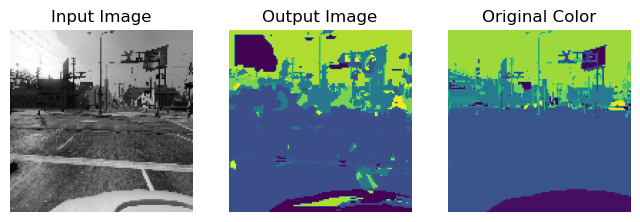

torch.Size([35, 128, 128])
torch.Size([128, 128])
tensor([[23, 23, 23,  ..., 11, 11, 11],
        [23, 23, 23,  ..., 11, 11, 11],
        [23, 23, 23,  ..., 11, 11, 11],
        ...,
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1]])


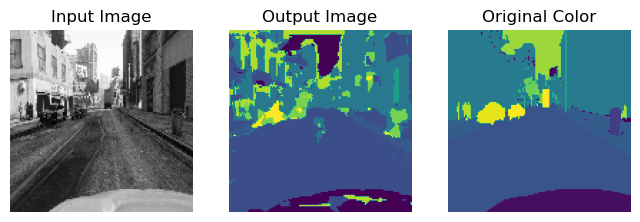

torch.Size([35, 128, 128])
torch.Size([128, 128])
tensor([[23, 23, 23,  ..., 23, 23, 23],
        [23, 23, 23,  ..., 23, 23, 23],
        [23, 23, 23,  ..., 23, 23, 23],
        ...,
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1]])


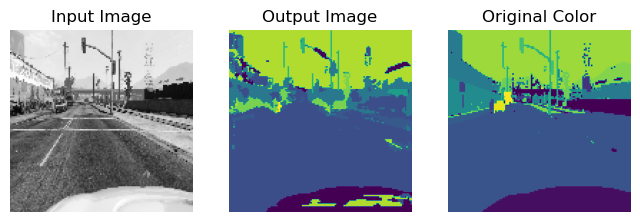

torch.Size([35, 128, 128])
torch.Size([128, 128])
tensor([[11, 11, 11,  ..., 23, 23, 23],
        [11, 11, 11,  ..., 23, 23, 23],
        [11, 11, 11,  ..., 23, 23, 23],
        ...,
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1]])


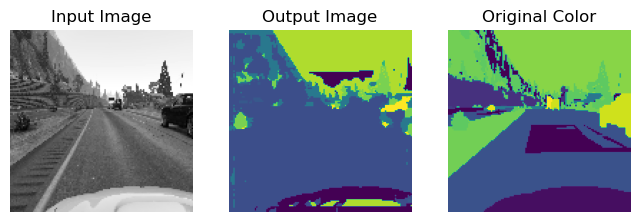

torch.Size([35, 128, 128])
torch.Size([128, 128])
tensor([[23, 23, 23,  ..., 11, 11, 11],
        [23, 23, 23,  ..., 11, 11, 11],
        [23, 23, 23,  ..., 11, 11, 11],
        ...,
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1]])


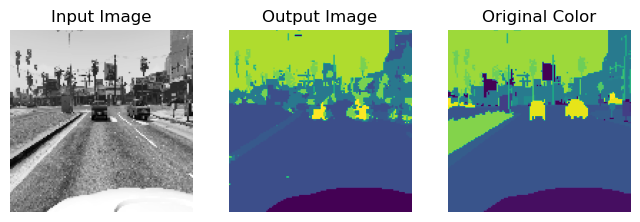

torch.Size([35, 128, 128])
torch.Size([128, 128])
tensor([[11, 11, 11,  ..., 23, 11, 11],
        [11, 11, 11,  ..., 23, 11, 11],
        [11, 11, 11,  ..., 23, 11, 11],
        ...,
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1]])


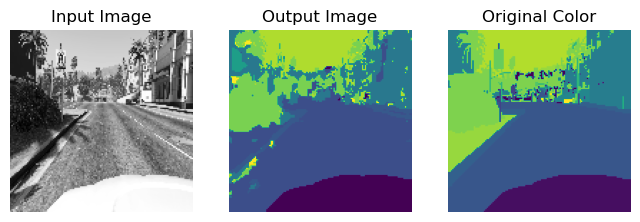

torch.Size([35, 128, 128])
torch.Size([128, 128])
tensor([[11, 11, 21,  ..., 21, 21, 21],
        [21, 21, 21,  ..., 21, 21, 21],
        [21, 23, 21,  ..., 21, 23, 21],
        ...,
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1]])


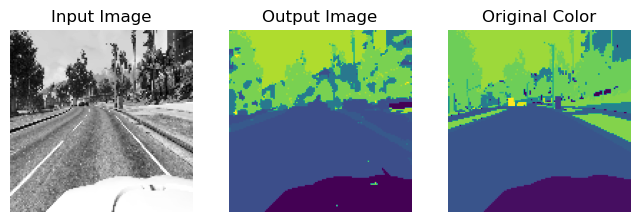

torch.Size([35, 128, 128])
torch.Size([128, 128])
tensor([[23, 11, 23,  ..., 11, 11, 11],
        [11, 23, 23,  ..., 23, 23, 23],
        [23, 23, 23,  ..., 23, 23, 23],
        ...,
        [ 7,  7,  7,  ...,  1,  1, 11],
        [ 7,  7,  7,  ...,  1,  7,  7],
        [ 7,  7,  7,  ...,  1,  1,  1]])


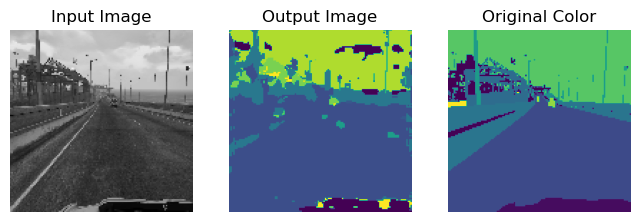

torch.Size([35, 128, 128])
torch.Size([128, 128])
tensor([[23, 23, 23,  ..., 11, 11, 11],
        [23, 23, 23,  ..., 11, 11, 11],
        [23, 23, 23,  ..., 11, 11, 11],
        ...,
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1]])


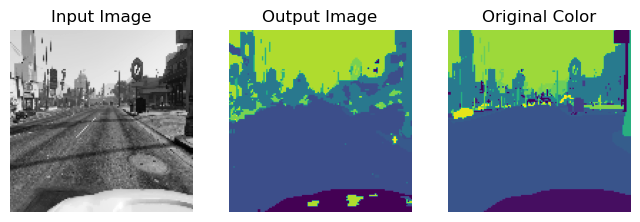

In [371]:
trained_seg_model.eval()
test_image = s_train_dataset[0][0]
#print(test_image.shape)
batch_size = 10
# Iterate through the test data
test_loader = DataLoader(s_test_dataset, batch_size=batch_size, shuffle=True)

counter = 0
for batch in test_loader:
    inputs, labels = batch  # You can ignore the labels
    if counter == 3:
        break
    else:
        counter += 1

    # Perform inference
    with torch.no_grad():
        outputs = trained_seg_model(inputs.to(device))

    # View the input and output images
    for i in range(3):
        input_img = inputs[i].squeeze().cpu()*50 + 50 # rescale [-1,1] --> [0, 100]
        input_labels = labels[i].cpu() # rescale [-1,1] --> [-128, 128]
        output_img = outputs[i].cpu() # rescale [-1,1] --> [-128, 128]
        
        print(output_img.shape)
        
        
        print(torch.sum(output_img, dim = 0).shape)
        # Network computed image
        output_indices = torch.argmax(output_img, dim = 0)
        print(output_indices)
       
        #color_img = torch.cat((input_img[0].unsqueeze(0) ,output_img[0].unsqueeze(0), output_img[1].unsqueeze(0)), dim=0).cpu() # restore Lab image
        #color_img = kornia.color.lab_to_rgb(color_img) #Lab --> RGB
        #color_img = color_img.permute(1, 2, 0).cpu().numpy()
        

        # Original Image
        #input_labels = F.interpolate(input_labels.unsqueeze(1), size=(img_size, img_size), mode='bilinear', align_corners=False).squeeze(1).cpu()
        #original_color_image = torch.cat((input_img[0].unsqueeze(0) ,input_labels[0].unsqueeze(0), input_labels[1].unsqueeze(0)), dim=0)
        #original_color_image = kornia.color.lab_to_rgb(original_color_image)
        original_segmented_img = torch.sum(input_labels, dim = 0).numpy()
        
        # Display the input and output images side by side
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(input_img, cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(output_indices.numpy())
        plt.title('Output Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        #plt.imshow(original_color_image.permute(1, 2, 0).numpy())
        plt.imshow(original_segmented_img)
        plt.title('Original Color')
        plt.axis('off')

        plt.show()

## 3.3 Save model

In [372]:

torch.save({'model_state_dict': trained_seg_model.state_dict(),
            'train_losses': train_seg_losses,
            'val_losses': val_seg_losses,
            }, "./trained_seg_model.ckpt")

# Example of creating and initialising model with a previously saved state dict:
saved_seg_model = SegModel() # fill-in the arguments if needed
checkpoint = torch.load("trained_seg_model.ckpt")
saved_seg_model.load_state_dict(checkpoint['model_state_dict'])

# Example of re-using saved statistics:
print("Validation accuracies:", checkpoint['val_losses'])

Validation accuracies: [1.581987996896108, 1.387422353029251, 1.2396417260169983, 1.239729642868042, 1.2179510990778606, 1.1276045342286427, 1.1349057604869206, 1.0862642675638199, 1.0823046068350475, 1.0543056180079777]


## 4. Create an Autoencoder that uses the Network  in 3.

Combine Semantic segmentation with a new autoencoder to colorize images.

### 4.1 Create Combined Model 

In [15]:
AutoEncoder2 = nn.Sequential(
    nn.Conv2d(2, 64, kernel_size=3, padding=1),
    nn.LeakyReLU(),  
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.LeakyReLU(),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.Dropout(0.5),
    nn.Conv2d(256, 128, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.Tanh(),
    nn.Conv2d(64, 2, kernel_size=3, padding=1),
    nn.Dropout(0.1),
    nn.Tanh()  
)




class CombinedModel(nn.Module):
    def __init__(self, modelA, modelB):
        super(CombinedModel, self).__init__()
        self.modelA = modelA # semantic segmentation
        self.modelB = modelB # colorization
        
        
    def forward(self, x):
        L = x
        seg = self.modelA(x)                     # [nr_channels, img_size, img_size]
        seg_one_img = torch.argmax(seg, dim = 1) # [img_size, img_size]
        LSeg = torch.cat([L,seg_one_img.unsqueeze(1)], dim=1) # [2, img_size, img_size]
        ab = self.modelB(LSeg)
        
        
        return ab


saved_seg_model = SegModel() # fill-in the arguments if needed
checkpoint = torch.load("trained_seg_model.ckpt")
saved_seg_model.load_state_dict(checkpoint['model_state_dict'])
combined = CombinedModel(saved_seg_model, AutoEncoder2)


### 4.2 Freeze Layers

In [16]:
for param in saved_seg_model.parameters():
    param.requires_grad = False

In [17]:
crop_size = (128, 128)
gta_combined_transform = Compose([ToTensor(), Resize(crop_size, interpolation=Image.NEAREST)])#Compose([ToTensor(), Resize((img_size, img_size), antialias=True)])
gta_combined_dataset = GTALabData(path, gta_combined_transform)

val_ratio = 0.15
test_ratio = 0.15

n_samples = len(gta_combined_dataset)
n_val_samples = int(n_samples * val_ratio)
n_test_samples = int(n_samples * test_ratio)
n_train_samples = n_samples - n_val_samples - n_test_samples

combined_train_dataset, combined_val_dataset, combined_test_dataset = random_split(
    gta_combined_dataset, [n_train_samples, n_val_samples, n_test_samples]
)

In [ ]:
# YOUR CODE HERE
batch_size = 32


train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(combined_val_dataset, batch_size=batch_size, shuffle=True)



optimizer = optim.Adam(combined.parameters(), lr =0.001)
loss_fn = nn.MSELoss()
num_epochs = 10
print_every = 1


    
trained_combined_model, train_losses, val_losses = training_loop(combined, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every)

Starting training
Batch 1/55: Train loss: 0.106
Batch 2/55: Train loss: 0.272
Batch 3/55: Train loss: 0.099
Batch 4/55: Train loss: 0.045
Batch 5/55: Train loss: 0.034
Batch 6/55: Train loss: 0.021
Batch 7/55: Train loss: 0.014
Batch 8/55: Train loss: 0.010
Batch 9/55: Train loss: 0.009
Batch 10/55: Train loss: 0.007
Batch 11/55: Train loss: 0.005
Batch 12/55: Train loss: 0.006
Batch 13/55: Train loss: 0.006
Batch 14/55: Train loss: 0.005
Batch 15/55: Train loss: 0.005
Batch 16/55: Train loss: 0.005
Batch 17/55: Train loss: 0.005
Batch 18/55: Train loss: 0.004
Batch 19/55: Train loss: 0.004
Batch 20/55: Train loss: 0.004
Batch 21/55: Train loss: 0.005
Batch 22/55: Train loss: 0.005
Batch 23/55: Train loss: 0.005
Batch 24/55: Train loss: 0.006
Batch 25/55: Train loss: 0.004
Batch 26/55: Train loss: 0.004
Batch 27/55: Train loss: 0.005
Batch 28/55: Train loss: 0.004
Batch 29/55: Train loss: 0.004
Batch 30/55: Train loss: 0.005
Batch 31/55: Train loss: 0.004
Batch 32/55: Train loss: 0.004

### 4.3 Evaluate Results

11.788355
tensor([[[ -2.8796,  -2.8796,  -2.6422,  ...,  -1.7677,  -2.2992,  -2.2992],
         [ -2.3518,  -2.6470,  -2.6470,  ...,  -2.2992,  -2.2992,  -1.2478],
         [ -2.2254,  -2.8223,  -2.8840,  ...,  -2.3035,  -2.5165,  -2.5125],
         ...,
         [ -2.5669,  -4.8583,  -4.2067,  ...,  -0.8735,  -1.2054,  -2.0922],
         [ -4.2067,  -3.3813,  -5.3019,  ...,  -0.1512,  -1.2121,  -1.1644],
         [ -4.2140,  -4.3299,  -1.6463,  ...,  -0.8892,   0.2348,  -1.2121]],

        [[-18.5667, -18.5667, -19.0701,  ..., -18.7110, -18.3136, -18.3136],
         [-18.9509, -19.0543, -19.0543,  ..., -18.3136, -18.3136, -15.6334],
         [-17.7366, -17.9454, -18.5514,  ..., -18.2985, -17.8710, -17.8859],
         ...,
         [ 12.5151,  14.3832,  13.7520,  ...,   6.6971,   7.7108,  11.6822],
         [ 13.7520,  12.7013,  14.5688,  ...,  11.7095,   6.5743,  10.0580],
         [ 13.8012,  14.0372,  11.8974,  ...,  11.7949,  10.9671,   6.5743]]])
torch.Size([128, 128]) shape
torch

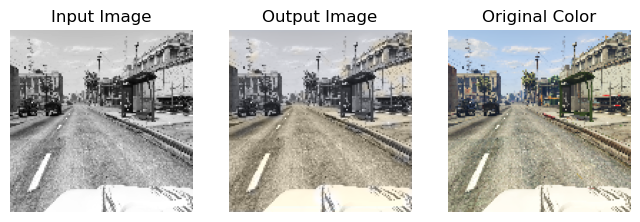

11.788354
tensor([[[  0.8845,   1.7973,  -0.2837,  ...,  -1.0570,  -1.0570,  -1.0570],
         [  0.2946,   3.7577,  -0.1094,  ...,  -0.6686,  -0.3482,  -0.3482],
         [  2.9155,  -2.9095,  -0.4817,  ...,  -0.6686,  -0.6686,  -0.8632],
         ...,
         [  1.5765,   0.8068,   0.9976,  ...,  -0.3780,  -0.7260,  -0.3780],
         [  0.0939,   0.5473,  -0.6430,  ...,  -0.7257,  -0.7257,  -0.8956],
         [  1.3320,  -0.6424,  -1.0031,  ...,  -0.7249,  -0.7253,  -0.7253]],

        [[-14.9030, -14.5110, -12.9413,  ...,  -6.9555,  -6.9555,  -6.9555],
         [-10.1811, -18.3602, -14.7322,  ...,  -7.9192,  -7.8059,  -7.8059],
         [-18.3774,  -7.7600, -13.3880,  ...,  -7.9192,  -7.9192,  -7.4375],
         ...,
         [ 10.7832,  11.5376,  12.0556,  ...,   5.4059,   5.2846,   5.4106],
         [ 12.4495,  13.6991,   9.8187,  ...,   5.2800,   5.2800,   5.7726],
         [ 13.9725,   9.8278,   9.5327,  ...,   5.2709,   5.2754,   5.2754]]])
torch.Size([128, 128]) shape
torch

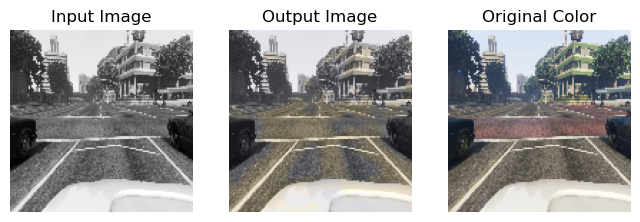

11.987313
tensor([[[ 7.5362,  8.0469,  6.6864,  ..., -5.1708,  9.8380, -1.8247],
         [ 8.2496,  8.0469,  6.2213,  ..., -0.8928,  5.4044,  3.4457],
         [ 7.5628,  7.5866,  6.4306,  ..., -1.1285, -1.4360, -1.6389],
         ...,
         [ 1.0680,  0.9563,  1.1420,  ..., -0.5434, -0.8820, -0.5434],
         [ 0.6336,  0.9741,  1.4545,  ..., -0.8816, -0.8816, -0.3770],
         [ 0.1081,  2.1302,  0.1195,  ..., -0.3770, -0.7147, -0.8816]],

        [[ 0.7409, -0.5363,  0.3656,  ...,  5.1476,  1.7709,  6.7798],
         [ 0.3081, -0.5363,  0.1693,  ...,  1.1058,  6.1078, -2.4183],
         [ 0.7489, -0.7392, -0.4845,  ...,  0.3384, 14.5978, -1.9889],
         ...,
         [-3.9984, -2.5192, -4.1767,  ...,  5.7465,  5.6285,  5.7465],
         [-4.0989, -2.5591, -2.4786,  ...,  5.6242,  5.6242,  5.2663],
         [-2.7815, -2.9365, -2.8571,  ...,  5.2623,  5.1444,  5.6242]]])
torch.Size([128, 128]) shape
torch.Size([3, 128, 128]) o


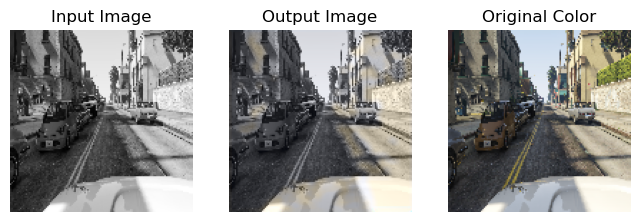

11.788354
tensor([[[  1.6344,   3.5035,   3.2789,  ..., -14.6932,   3.7050,  -6.8622],
         [  2.8876,   6.3506,   6.8114,  ...,   1.9264,  -7.1184,  -3.5945],
         [  3.4043,   6.2510,   6.2288,  ...,  -0.8630,  -8.8867,  -1.7054],
         ...,
         [ -1.5150,  -2.2801,  -2.5021,  ...,  -0.0400,  -0.0400,  -0.0400],
         [ -1.3961,  -2.6115,  -1.2310,  ...,   0.1309,   0.1309,   0.1309],
         [ -1.7365,  -0.6685,   0.2331,  ...,  -0.2053,  -0.2053,  -0.0402]],

        [[-13.5852, -17.0380, -17.4811,  ...,  17.3700,  -2.6137,  -2.2861],
         [-15.9086, -23.9706, -24.9000,  ...,  15.5429,   6.4547,   3.8549],
         [-16.9264, -24.5080, -24.7580,  ...,  -7.4673,  -1.5748,   7.5119],
         ...,
         [ -8.3007,  -5.6138,  -5.0973,  ...,   3.2467,   3.2467,   3.2467],
         [ -7.7246,  -5.6791,  -5.2183,  ...,   2.7626,   2.7626,   2.7626],
         [ -7.7517,  -5.6776, -10.0326,  ...,   2.6424,   2.6424,   3.2416]]])
torch.Size([128, 128]) shape
torch

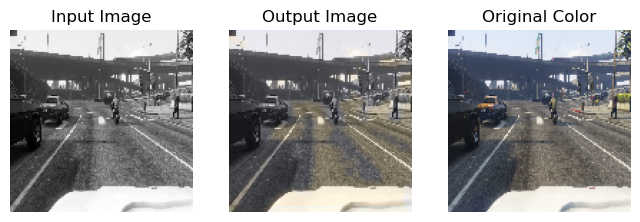

11.788354
tensor([[[  2.0876,   2.0876,   2.0678,  ...,   0.7726,   0.4906,   0.9836],
         [  2.0876,   2.4422,   2.4422,  ...,   0.7666,   0.2593,   0.2565],
         [  2.4624,   2.4624,   2.4422,  ...,   0.7666,   0.9836,   1.2648],
         ...,
         [  1.4130,   1.5260,   0.9712,  ...,   7.1826,   7.6098,   6.9678],
         [  1.3569,   1.8838,   1.4697,  ...,   7.1641,   7.1826,   7.1826],
         [  1.4130,   1.4697,   1.4697,  ...,   6.9778,   7.3988,   7.3988]],

        [[-12.0649, -12.0649, -12.0345,  ...,   2.6273,   1.7375,   1.9069],
         [-12.0649, -11.9297, -11.9297,  ...,   2.6138,   2.4229,   2.4112],
         [-11.9604, -11.9604, -11.9297,  ...,   2.6138,   1.9069,   2.7825],
         ...,
         [ -3.8459,  -5.0347,  -2.6435,  ...,  -6.3353,  -6.1782,  -5.7447],
         [ -3.6932,  -4.8706,  -3.9885,  ...,  -6.3207,  -6.3353,  -6.3353],
         [ -3.8459,  -3.9885,  -3.9885,  ...,  -7.0738,  -6.9219,  -6.9219]]])
torch.Size([128, 128]) shape
torch

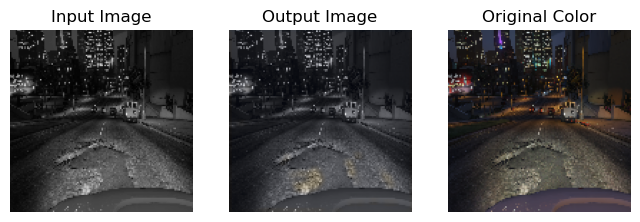

11.788353
tensor([[[ -1.2468,  -1.0553,  -0.8633,  ...,   1.0352,   0.9951,   1.7466],
         [ -0.7351,  -0.6707,  -0.6707,  ...,   0.4096,   0.7551,   0.8168],
         [ -1.2463,  -0.8632,  -0.8632,  ...,   0.8274,   0.7426,   0.8362],
         ...,
         [ -1.1437,  -1.3788,  -1.0200,  ...,  -1.2870,  -1.2886,  -1.5161],
         [ -1.5015,  -1.6126,  -2.2120,  ...,  -1.5172,  -1.5183,  -1.2948],
         [ -1.1442,  -1.8467,  -1.8494,  ...,  -1.5203,  -1.5213,  -1.5222]],

        [[ -6.4330,  -6.9122,  -7.3912,  ..., -14.1670, -14.0934, -16.9389],
         [ -6.7995,  -7.8639,  -7.8639,  ..., -13.7029, -13.6056, -15.2107],
         [ -6.4280,  -7.3799,  -7.3799,  ..., -14.4959, -13.5817, -15.2391],
         ...,
         [ -6.7508,  -6.1301,  -6.0513,  ..., -10.5700, -10.5582, -10.0299],
         [ -6.8333,  -5.6150,  -5.2185,  ..., -10.0187, -10.0077, -10.5115],
         [ -6.7402,  -5.0776,  -5.0936,  ...,  -9.9857,  -9.9749,  -9.9641]]])
torch.Size([128, 128]) shape
torch

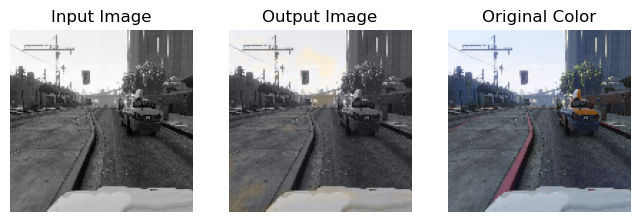

11.788355
tensor([[[-6.0782e-01, -9.8398e-01,  6.8814e-02,  ..., -1.0752e+00,
          -1.0752e+00, -1.6184e+00],
         [-3.8227e-01, -5.2509e-01, -5.2199e-01,  ..., -1.6184e+00,
          -1.6184e+00, -1.6184e+00],
         [-1.1241e+01, -5.2428e-01, -1.5372e-01,  ..., -1.3106e+00,
          -1.3106e+00, -1.3106e+00],
         ...,
         [-4.8834e-01, -2.2090e+00, -9.6670e-01,  ..., -1.8877e+00,
          -7.8082e-03, -2.3882e+00],
         [-1.8672e+00, -1.1277e+00,  1.4087e+00,  ..., -2.0552e+00,
          -1.7196e+00, -2.1788e+00],
         [ 1.1380e+00,  7.5829e-01,  7.7346e-01,  ..., -1.1191e+00,
          -1.7041e+00, -1.7196e+00]],

        [[-4.0174e+00, -4.2103e+00, -5.6668e+00,  ..., -1.6549e+01,
          -1.6549e+01, -1.6145e+01],
         [-4.5890e+00, -5.2262e+00, -5.2854e+00,  ..., -1.6145e+01,
          -1.6145e+01, -1.6145e+01],
         [ 4.3484e+01, -5.2427e+00, -5.1552e+00,  ..., -1.6036e+01,
          -1.6036e+01, -1.6036e+01],
         ...,
         [ 1.40

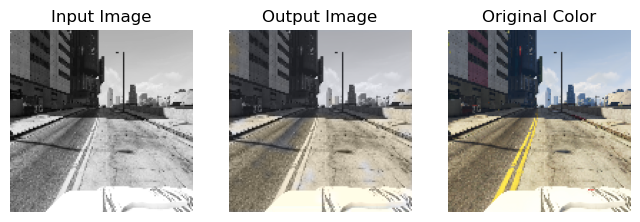

11.788352
tensor([[[ 1.8286e+01,  1.7583e+01,  1.7149e+01,  ...,  2.2838e+01,
           2.1966e+01,  2.1341e+01],
         [ 1.7583e+01,  1.7768e+01,  1.7574e+01,  ...,  2.1730e+01,
           2.0333e+01,  2.0333e+01],
         [ 1.7387e+01,  1.7387e+01,  1.7194e+01,  ...,  2.0721e+01,
           2.0333e+01,  2.0721e+01],
         ...,
         [ 3.4773e+00,  3.1896e+00,  2.5793e+00,  ...,  3.2109e+00,
           5.0390e-01,  1.6466e-02],
         [ 2.9772e+00,  3.7050e+00,  3.0595e+00,  ...,  2.9915e+00,
           8.6814e-01, -3.4437e-01],
         [ 2.9727e+00,  2.3621e+00,  3.7428e+00,  ...,  4.0115e+00,
           2.3480e+00,  6.9126e-01]],

        [[ 5.5929e-01,  1.4634e+00,  5.8460e-02,  ...,  3.2313e+00,
           1.5393e+00,  6.0252e-01],
         [ 1.4634e+00,  9.3381e-01,  2.3543e-01,  ...,  7.9144e-01,
          -5.1662e-01, -5.1662e-01],
         [ 7.6641e-01,  7.6641e-01,  6.8331e-02,  ..., -3.3031e-01,
          -5.1662e-01, -3.3031e-01],
         ...,
         [-6.19

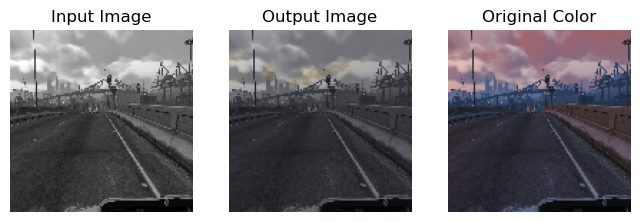

11.788353
tensor([[[ 1.2061,  0.8706,  0.6903,  ..., -0.2413,  0.0906, -0.0953],
         [ 0.5375,  0.3566,  1.0657,  ...,  0.0906, -0.4277, -0.0953],
         [ 0.2037,  0.5380,  0.6267,  ..., -0.0953, -0.0953, -0.0953],
         ...,
         [-1.2320, -1.4300, -0.6268,  ..., -2.1311, -1.7660, -1.7651],
         [-2.6553, -2.4274, -1.2300,  ..., -1.9601, -1.9601, -2.1284],
         [-2.4729, -1.0319, -1.0105,  ..., -2.3216, -1.7895, -1.9575]],

        [[-1.2158, -1.3339, -0.8478,  ..., -3.3987, -3.2815, -2.7912],
         [-1.4548, -0.9679, -1.8441,  ..., -3.2815, -2.9084, -2.7912],
         [-1.5744, -1.4561, -5.0540,  ..., -2.7912, -2.7912, -2.7912],
         ...,
         [ 3.4604,  4.0384,  3.0350,  ...,  8.3912,  8.5160,  8.5073],
         [ 2.3437,  3.0183,  3.4537,  ...,  7.8728,  7.8728,  8.3740],
         [ 3.0777,  2.8827,  4.1247,  ...,  7.7409,  7.3632,  7.8568]]])
torch.Size([128, 128]) shape
torch.Size([3, 128, 128]) o


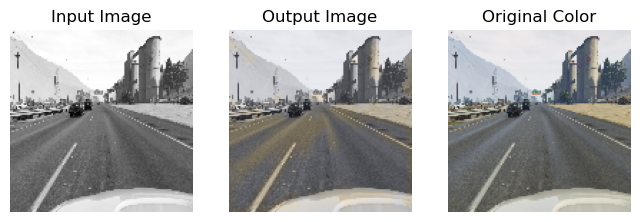

In [62]:
trained_combined_model.eval()

#print(test_image.shape)
batch_size = 10
# Iterate through the test data
test_loader = DataLoader(combined_test_dataset, batch_size=batch_size, shuffle=True)


counter = 0
for batch in test_loader:
    inputs, labels = batch  # You can ignore the labels
    if counter == 3:
        break
    else:
        counter += 1

    # Perform inference
    with torch.no_grad():
        outputs = trained_combined_model(inputs.to(device))

    # View the input and output images
    for i in range(3):
        input_img = inputs[i].squeeze().cpu()*50 + 50 # rescale [-1,1] --> [0, 100]
        input_labels = labels[i].squeeze().cpu()*128 # rescale [-1,1] --> [-128, 128]
        output_img = outputs[i].cpu()*128 # rescale [-1,1] --> [-128, 128]
        print(np.max(output_img.numpy()))
        print(input_labels)
        print(input_img.shape, 'shape')

        # Network computed image
        color_img = torch.cat((input_img.unsqueeze(0) ,output_img[0].unsqueeze(0), output_img[1].unsqueeze(0)), dim=0).cpu() # restore Lab image
        color_img = kornia.color.lab_to_rgb(color_img) #Lab --> RGB
        color_img = color_img.permute(1, 2, 0).cpu().numpy()
        

        # Original Image
        #input_labels = F.interpolate(input_labels.unsqueeze(1), size=(img_size, img_size), mode='bilinear', align_corners=False).squeeze(1).cpu()
        original_color_image = torch.cat((input_img.unsqueeze(0) ,input_labels[0].unsqueeze(0), input_labels[1].unsqueeze(0)), dim=0)
        original_color_image = kornia.color.lab_to_rgb(original_color_image)
        print(original_color_image.shape, 'o')

        # Display the input and output images side by side
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(input_img, cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(color_img)
        plt.title('Output Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(original_color_image.permute(1, 2, 0).numpy())
        plt.title('Original Color')
        plt.axis('off')

        plt.show()

#output = trained_gta_model(test_image)
#test_dataloader = DataLoader()

### 4.4 Save Model

In [74]:

torch.save({'model_state_dict': trained_combined_model.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            }, "./trained_combined_model.ckpt")
'''
# Example of creating and initialising model with a previously saved state dict:
saved_combined_model = CombinedModel() # fill-in the arguments if needed
checkpoint = torch.load("trained_combined_model.ckpt")
saved_combined_model.load_state_dict(checkpoint['model_state_dict'])

# Example of re-using saved statistics:
print("Validation accuracies:", checkpoint['val_losses'])
'''

'\n# Example of creating and initialising model with a previously saved state dict:\nsaved_combined_model = CombinedModel() # fill-in the arguments if needed\ncheckpoint = torch.load("trained_combined_model.ckpt")\nsaved_combined_model.load_state_dict(checkpoint[\'model_state_dict\'])\n\n# Example of re-using saved statistics:\nprint("Validation accuracies:", checkpoint[\'val_losses\'])\n'

## 5. Compare the Two Autoencoders

torch.Size([1, 256, 256]) torch.Size([256, 256])


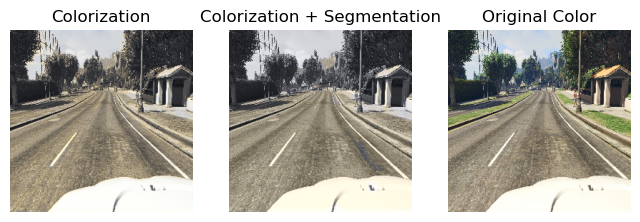

torch.Size([1, 256, 256]) torch.Size([256, 256])


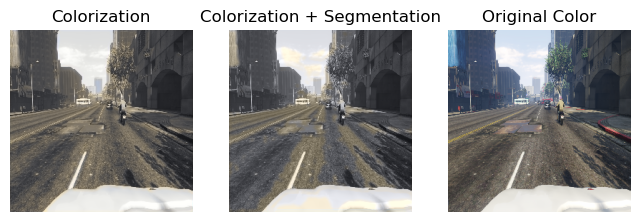

torch.Size([1, 256, 256]) torch.Size([256, 256])


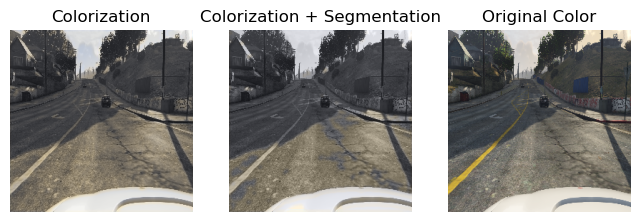

torch.Size([1, 256, 256]) torch.Size([256, 256])


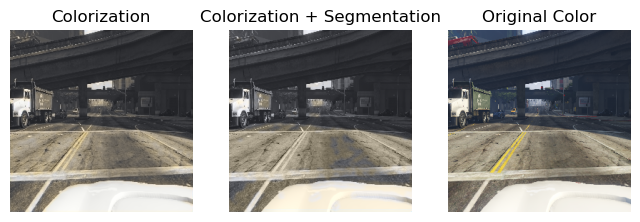

torch.Size([1, 256, 256]) torch.Size([256, 256])


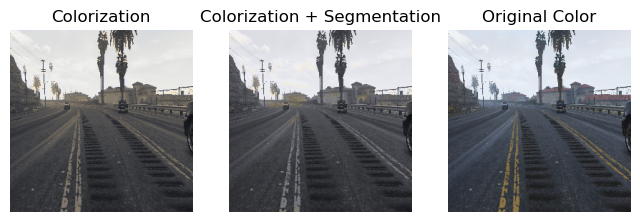

torch.Size([1, 256, 256]) torch.Size([256, 256])


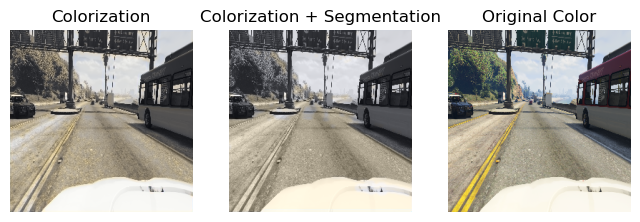

torch.Size([1, 256, 256]) torch.Size([256, 256])


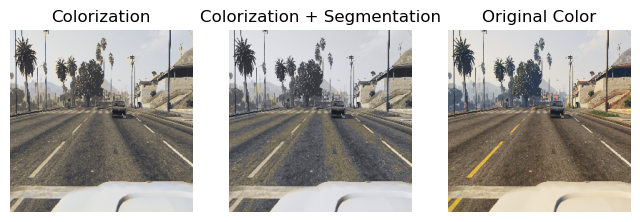

torch.Size([1, 256, 256]) torch.Size([256, 256])


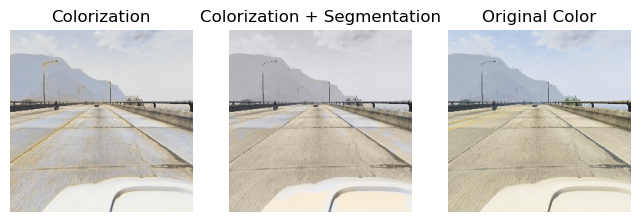

torch.Size([1, 256, 256]) torch.Size([256, 256])


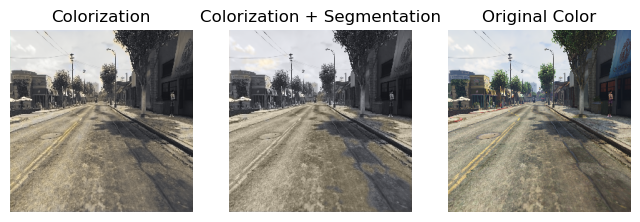

In [123]:
'''
#Load Old Model no Segmentation

saved_single_model = AutoEncoder() # fill-in the arguments if needed
checkpoint = torch.load("saved_single_model.ckpt")
saved_single_model.load_state_dict(checkpoint['model_state_dict'])

#Load Seg Model
saved_seg_model = SegModel() # fill-in the arguments if needed
checkpoint = torch.load("trained_seg_model.ckpt")
saved_seg_model.load_state_dict(checkpoint['model_state_dict'])

#Load New Model with Segmentation

saved_combined_model = CombinedModel(saved_seg_model, AutoEncoder2)
checkpoint = torch.load("trained_combined_model.ckpt")
saved_combined_model.load_state_dict(checkpoint['model_state_dict'])




# Load in an image

crop_size = (512, 512)
transform =  Compose([ToTensor(), Resize(crop_size, interpolation=Image.NEAREST)])
newDataset = GTALabData(path, transform)
L, ab = newDataset[5]


# Get output Data
saved_single_model.eval()
with torch.no_grad():
    output_single = model(L.to(device))


_combined_model.eval()
with torch.no_grad():
    output_combined = model(L.to(device))
'''

#Load Old Model no Segmentation

saved_single_model = AutoEncoder() # fill-in the arguments if needed
checkpoint = torch.load("trained_single_model.ckpt")
saved_single_model.load_state_dict(checkpoint['model_state_dict'])

#Load Seg Model
saved_seg_model = SegModel() # fill-in the arguments if needed
checkpoint = torch.load("trained_seg_model.ckpt")
saved_seg_model.load_state_dict(checkpoint['model_state_dict'])

#Load New Model with Segmentation

saved_combined_model = CombinedModel(saved_seg_model, AutoEncoder2)
checkpoint = torch.load("trained_combined_model.ckpt")
saved_combined_model.load_state_dict(checkpoint['model_state_dict'])

batch_size = 10
crop_size = (256, 256)
transform =  Compose([ToTensor(), Resize(crop_size, interpolation=Image.NEAREST)])
newDataset = GTALabData(path, transform)
L, ab = newDataset[5]

test_loader = DataLoader(newDataset, batch_size=batch_size, shuffle=True)


counter = 0
for batch in test_loader:
    L, ab = batch  # You can ignore the labels
    if counter >= 3:
        break
    else:
        counter += 1
    

    # Get output Data
    saved_single_model.eval()
    with torch.no_grad():
        output1 = saved_single_model(L)


    trained_combined_model.eval()
    with torch.no_grad():
        output2 = trained_combined_model(L.to(device))

    for i in range(3):

        #Make Plots

        input_img = L[i].squeeze().cpu()*50 + 50 # rescale [-1,1] --> [0, 100]
        input_labels = ab[i].squeeze().cpu()*128 # rescale [-1,1] --> [-128, 128]
        output_single = output1[i].cpu()*128 # rescale [-1,1] --> [-128, 128]
        output_combined = output2[i].cpu()*128

        # AutoEnconder
        auto_img = torch.cat((input_img.unsqueeze(0) ,output_single[0].unsqueeze(0), output_single[1].unsqueeze(0)), dim=0).cpu() # restore Lab image
        auto_img = kornia.color.lab_to_rgb(auto_img) #Lab --> RGB
        auto_img = auto_img.permute(1,2,0)
        

        # CombinedModel
        combined_img = torch.cat((input_img.unsqueeze(0) ,output_combined[0].unsqueeze(0), output_combined[1].unsqueeze(0)), dim=0).cpu() # restore Lab image
        combined_img = kornia.color.lab_to_rgb(combined_img) #Lab --> RGB
        combined_img = combined_img.permute(1, 2, 0)
        

        # Original Image
        
        original_color_image = torch.cat((input_img.unsqueeze(0) ,input_labels[0].unsqueeze(0), input_labels[1].unsqueeze(0)), dim=0)
        original_color_image = kornia.color.lab_to_rgb(original_color_image)


        # Display the input and output images side by side
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(auto_img)
        plt.title('Colorization')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(combined_img)
        plt.title('Colorization + Segmentation')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(original_color_image.permute(1, 2, 0).numpy())
        plt.title('Original Color')
        plt.axis('off')

        plt.show()